# 02_05_Solution: Pre-train a Foundation Model

## Import the Necessary Libraries

In [1]:
import pandas as pd
import boto3
import sagemaker
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import os

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


2025-05-11 22:40:01.654977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 22:40:01.669161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747003201.688411    1753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747003201.694463    1753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 22:40:01.712876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load and preprocess the Legal dataset

In [2]:
df = pd.read_csv('AmznSagemaker_3942119_dataset.csv')
df

,DocumentID,Title,LegalText,Source
0,DOC001,Court Opinion - Intellectual Property Case,The Receiving Party agrees not to disclose any...,Public Domain - Court Opinion
1,DOC002,Terms of Service - E-commerce Platform,The Receiving Party agrees not to disclose any...,Court Ruling - Privacy Violation
2,DOC003,Contract - Non-Disclosure Agreement (NDA),"We collect data such as your name, email, and ...",Public Notice - Consumer Rights Act
3,DOC004,Supreme Court Opinion - Freedom of Speech,Consumers are entitled to clear and concise in...,Public Domain - Court Opinion
4,DOC005,Contract - Non-Disclosure Agreement (NDA),The court held that the unauthorized use of pa...,Public Document - ToS
...,...,...,...,...
495,DOC496,Public Notice - Consumer Rights,Data should be retained only as long as necess...,Policy Document - Data Retention Guidelines
496,DOC497,Court Ruling - Data Privacy Violation,The ruling emphasized the need for organizatio...,Public Document - ToS
497,DOC498,Court Ruling - Data Privacy Violation,The ruling emphasized the need for organizatio...,Public Domain - Court Opinion
498,DOC499,Legal Policy - Data Retention,The court held that the unauthorized use of pa...,Public Domain - Court Opinion


In [3]:
# Combine 'Title' and 'LegalText' into a single 'text' field
df['text'] = df['Title'].fillna('') + " " + df['LegalText'].fillna('')

# Drop rows with missing text
df = df[df['text'].str.strip() != '']

# Keep only 'text' column
df = df[['text']]
df.head()

,text
0,Court Opinion - Intellectual Property Case The...
1,Terms of Service - E-commerce Platform The Rec...
2,Contract - Non-Disclosure Agreement (NDA) We c...
3,Supreme Court Opinion - Freedom of Speech Cons...
4,Contract - Non-Disclosure Agreement (NDA) The ...


## Split into train/test

In [4]:
from sklearn.model_selection import train_test_split

train_texts, test_texts = train_test_split(df['text'].tolist(), test_size=0.2, random_state=42)

train_dataset = Dataset.from_dict({'text': train_texts})
test_dataset = Dataset.from_dict({'text': test_texts})

## Save training and testing data as CSV files

In [5]:
# Specify the file path for the CSV file
train_file_path = "train_dataset.csv"
test_file_path = "test_dataset.csv"

# Save the dataset to a CSV file
train_dataset.to_csv(train_file_path)
test_dataset.to_csv(test_file_path)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

16102

## Tokenize datasets

In [6]:
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

[05/11/25 22:40:03] WARNING  Parameter 'function'=<function tokenize_function at 0x7ff05111ade0> ]8;id=76488;file:///opt/conda/lib/python3.12/site-packages/datasets/fingerprint.py\fingerprint.py]8;;\:]8;id=978253;file:///opt/conda/lib/python3.12/site-packages/datasets/fingerprint.py#328\328]8;;\
                             of the transform datasets.arrow_dataset.Dataset._map_single                           
                             couldn't be hashed properly, a random hash was used instead. Make                     
                             sure your transforms and parameters are serializable with pickle or                   
                             dill for the dataset fingerprinting and caching to work. If you                       
                             reuse this transform, the caching mechanism will consider it to be                    
                             different from the previous calls and recompute everything. This                      
                             warning is only showed once. Subsequent hashing failures won't be                     
                             showed.                                                                               

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Create data collator for masked language modeling

In [7]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=True, 
    mlm_probability=0.15
)

## Load model with random initialization (pre-training style)

In [8]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

## Set up SageMaker Estimator inside the Notebook

In [9]:
# Training arguments
output_dir = './results'

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=f'{output_dir}/logs',
    logging_steps=10,
)

## Define Trainer and start training

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.403500,0.624673
2,0.293300,0.329919
3,0.301200,0.235383


TrainOutput(global_step=75, training_loss=0.8136949253082275, metrics={'train_runtime': 41.495, 'train_samples_per_second': 28.919, 'train_steps_per_second': 1.807, 'total_flos': 39768346828800.0, 'train_loss': 0.8136949253082275, 'epoch': 3.0})

## Plot the training vs validation loss

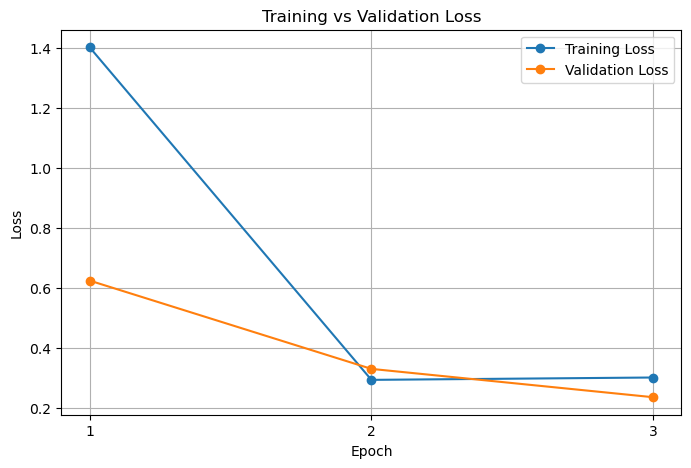

In [11]:
import matplotlib.pyplot as plt

# Re-create the plot after environment reset
epochs = [1, 2, 3]
training_loss = [1.4035, 0.2933, 0.3012]
validation_loss = [0.624673, 0.329919, 0.235383]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

## Save the model after training

In [12]:
model.save_pretrained('./legal-mlm-model')
tokenizer.save_pretrained('./legal-mlm-model')

print("✅ Model and tokenizer saved!")

✅ Model and tokenizer saved!


## Load the model and tokenizer from the saved directory

In [13]:
from transformers import pipeline, AutoModelForMaskedLM, AutoTokenizer

model = AutoModelForMaskedLM.from_pretrained('./legal-mlm-model')
tokenizer = AutoTokenizer.from_pretrained('./legal-mlm-model')

# Create a pipeline for fill-mask task
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


## Test the model

In [14]:
test_sentences = [
    "The judge issued a [MASK] after hearing the arguments.",
    "The attorney filed a [MASK] to dismiss the case.",
    "The settlement agreement was [MASK] by all parties.",
    "The witness was asked to [MASK] under oath.",
    "The defendant was found [MASK] by the jury.",
    "The contract must be [MASK] according to state law.",
    "The appeal was [MASK] by the higher court.",
    "The plaintiff sought [MASK] for damages.",
    "The case was [MASK] due to lack of evidence.",
    "The legal team prepared a [MASK] of evidence."
]

# Run the model on each sentence
for sentence in test_sentences:
    predictions = fill_mask(sentence)
    print(f"\nOriginal: {sentence}")
    for pred in predictions:
        print(f">>> {pred['sequence']} (score: {round(pred['score'], 4)})")


Original: The judge issued a [MASK] after hearing the arguments.
>>> the judge issued a ruling after hearing the arguments. (score: 0.9205)
>>> the judge issued a statement after hearing the arguments. (score: 0.0177)
>>> the judge issued a notice after hearing the arguments. (score: 0.0153)
>>> the judge issued a warning after hearing the arguments. (score: 0.0045)
>>> the judge issued a judgment after hearing the arguments. (score: 0.0045)

Original: The attorney filed a [MASK] to dismiss the case.
>>> the attorney filed a motion to dismiss the case. (score: 0.8366)
>>> the attorney filed a lawsuit to dismiss the case. (score: 0.0551)
>>> the attorney filed a petition to dismiss the case. (score: 0.0529)
>>> the attorney filed a request to dismiss the case. (score: 0.0241)
>>> the attorney filed a demand to dismiss the case. (score: 0.0074)

Original: The settlement agreement was [MASK] by all parties.
>>> the settlement agreement was agreed by all parties. (score: 0.3953)
>>> the s